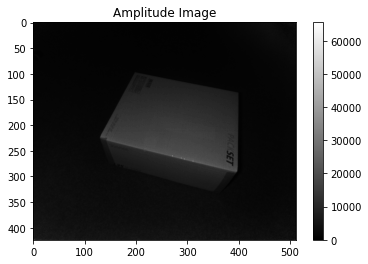

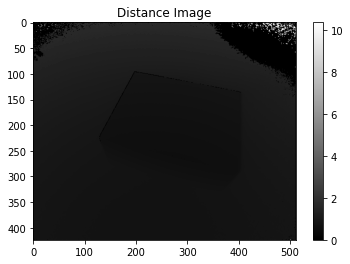

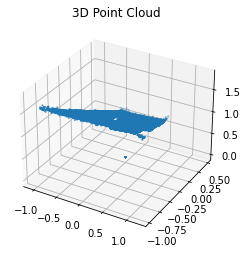

In [13]:
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to load data
def load_data(file_path):
    # Load .mat file
    data = scipy.io.loadmat(file_path)
    return data[list(data.keys())[3]], data[list(data.keys())[4]], data[list(data.keys())[5]]

# Visualization functions
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

def show_point_cloud(pc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:, :, 0], pc[:, :, 1], pc[:, :, 2], s=1)
    ax.set_title('3D Point Cloud')
    plt.show()

# Load your data
amplitude_image, distance_image, point_cloud = load_data('data/example1kinect.mat')

# Display images
show_image(amplitude_image, 'Amplitude Image')
show_image(distance_image, 'Distance Image')

# Display point cloud
show_point_cloud(point_cloud)


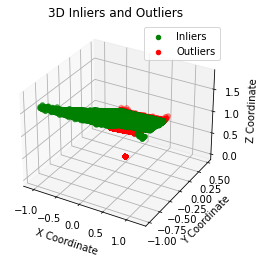

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def ransac_point_cloud(pc, threshold, max_iterations):
    best_plane = None
    best_inliers = None
    best_indices = None  # This will store the 2D indices of the best inliers
    height, width, _ = pc.shape

    for _ in range(max_iterations):
        # Randomly sample 3 points to define a plane
        sample_indices = np.random.choice(height * width, 3, replace=False)
        rows, cols = np.unravel_index(sample_indices, (height, width))
        p1, p2, p3 = pc[rows[0], cols[0]], pc[rows[1], cols[1]], pc[rows[2], cols[2]]

        if np.any(p1[2] == 0 or p2[2] == 0 or p3[2] == 0):  # Check if the z-component is zero
            continue

        # Calculate plane parameters
        normal_vector = np.cross(p2 - p1, p3 - p1)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        d = -np.dot(normal_vector, p1)

        # Count inliers
        all_points = pc.reshape(-1, 3)
        distances = np.abs(np.dot(all_points, normal_vector) + d) / np.linalg.norm(normal_vector)
        inliers = distances < threshold

        # Update best model if the current one has more inliers
        if best_inliers is None or np.count_nonzero(inliers) > np.count_nonzero(best_inliers):
            best_plane = (normal_vector, d)
            best_inliers = inliers
            best_indices = np.argwhere(inliers.reshape(height, width))  # Convert boolean mask back to indices

    # Extracting actual inlier points and their indices
    inlier_points = np.array([pc[i, j] for i, j in best_indices])
    return best_plane, inlier_points, best_indices

# Parameters
threshold = 0.085  # Distance threshold for inliers
max_iterations = 3000  # Maximum number of iterations

# Assuming point_cloud is the loaded 3D point cloud data with shape (x, y, 3)
plane, inlier_points, inlier_indices = ransac_point_cloud(point_cloud, threshold, max_iterations)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_inliers_and_outliers(point_cloud, inlier_indices):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a full mask for the point cloud and set inliers to True
    full_mask = np.zeros(point_cloud.shape[:2], dtype=bool)
    full_mask[tuple(inlier_indices[:, 0]), tuple(inlier_indices[:, 1])] = True

    # Outlier mask is the inverse of the inlier mask
    outlier_mask = ~full_mask

    # Extract inlier and outlier points using the masks
    inlier_points = point_cloud[full_mask]
    outlier_points = point_cloud[outlier_mask]

    # Plotting all inlier points (green)
    ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], color='g', marker='o', label='Inliers')

    # Plotting all outlier points (red)
    ax.scatter(outlier_points[:, 0], outlier_points[:, 1], outlier_points[:, 2], color='r', marker='o', label='Outliers')

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.legend()
    plt.title('3D Inliers and Outliers')
    plt.show()

# Example usage assuming `point_cloud` is the full dataset and `inlier_indices` is provided by RANSAC
visualize_inliers_and_outliers(point_cloud, inlier_indices)



In [15]:
def visualize_inliers(pc, inliers):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    inlier_points = np.array([pc[i, j] for i, j in np.argwhere(inliers)])
    outlier_points = np.array([pc[i, j] for i, j in np.argwhere(~inliers)])
    ax.scatter(outlier_points[:, 0], outlier_points[:, 1], outlier_points[:, 2], color='r', s=1)
    ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], color='g', s=1)
    ax.set_title('RANSAC Inliers and Outliers')
    plt.show()

In [ ]:
def create_inlier_mask(inliers, shape):
    """Create a mask from inliers boolean array with the given shape."""
    return inliers.reshape(shape)

# Assuming `inliers` is returned from the RANSAC function and has the correct number of elements
# Assuming `point_cloud` is the loaded 3D point cloud data with shape (x, y, 3)
mask = create_inlier_mask(inliers, point_cloud.shape[:2])

import matplotlib.pyplot as plt

def visualize_mask(mask, title="Inliers Mask"):
    """Visualize a 2D mask."""
    plt.figure(figsize=(10, 5))
    plt.imshow(mask, cmap='gray', interpolation='none')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Visualize the created mask
visualize_mask(mask)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

def apply_morphological_filters_to_mask(mask, size=3):
    """ Apply binary closing and opening to refine the mask """
    structure = np.ones((size, size))  # Create a 2D structure for morphological operations
    closed_mask = ndimage.binary_closing(mask, structure=structure)
    cleaned_mask = ndimage.binary_opening(closed_mask, structure=structure)
    return cleaned_mask

def create_binary_mask_from_indices(shape, indices):
    """ Create a binary mask from inlier indices """
    mask = np.zeros(shape, dtype=bool)
    mask[tuple(indices.T)] = True  # Use tuple for multi-dimensional indexing
    return mask

def extract_points_from_mask(pc, mask):
    """ Extract point cloud points corresponding to the mask """
    filtered_points = np.empty_like(pc)
    filtered_points[:] = np.nan  # Initialize with NaNs
    filtered_points[mask] = pc[mask]  # Copy only the points where mask is True
    filtered_indices = np.argwhere(mask)  # Get the indices of the filtered points
    return filtered_points, filtered_indices

# Assuming `inlier_indices` is a Nx2 array of (row, col) inlier indices from RANSAC
shape = point_cloud.shape[:2]  # Shape of the 2D representation of the point cloud

# Create a binary mask from inlier indices
binary_mask = create_binary_mask_from_indices(shape, inlier_indices)

# Apply morphological filters to the binary mask
cleaned_mask = apply_morphological_filters_to_mask(binary_mask, size=5)

# Extract the filtered points and their corresponding indices from the cleaned mask
filtered_points, filtered_indices = extract_points_from_mask(point_cloud, cleaned_mask)

# Visualization function for showing the mask
def visualize_mask(mask, title="Filtered Mask"):
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Visualize the cleaned mask
visualize_mask(cleaned_mask, "Morphologically Filtered Mask")


In [ ]:
# Assuming filtered_points is the filtered 3D point cloud data
plane, box_inliers, box_inlier_indices = ransac_point_cloud(filtered_points, 0.05, 2000)

# Visualization of the inliers in the filtered point cloud
def visualize_filtered_inliers(pc, inliers):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    inlier_points = pc[inliers]
    outlier_points = pc[~inliers]
    ax.scatter(outlier_points[:, 0], outlier_points[:, 1], outlier_points[:, 2], color='red', s=1)
    ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], color='green', s=1)
    ax.set_title('RANSAC Inliers and Outliers in Filtered Data')
    plt.show()

visualize_inliers(filtered_points, box_inliers)


In [ ]:
binary_mask = np.zeros(point_cloud.shape[:2], dtype=bool)
visualize_inliers_on_image(binary_mask, box_inlier_indices, "Inliers on Amplitude Image")


In [ ]:
import scipy.ndimage as ndimage

def apply_morphological_filters(binary_mask, size=3):
    # Apply binary closing and opening to remove noise and fill gaps
    structure = np.ones((size, size))
    closed_mask = ndimage.binary_closing(binary_mask, structure=structure)
    cleaned_mask = ndimage.binary_opening(closed_mask, structure=structure)
    return cleaned_mask

# Convert inliers to a binary mask
binary_mask = np.zeros(point_cloud.shape[:2], dtype=bool)
binary_mask[inliers.reshape(point_cloud.shape[:2])] = True

# Apply morphological filtering
cleaned_mask = apply_morphological_filters(binary_mask)


# Visualization function for the mask
def show_mask(mask, title):
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.show()

show_mask(cleaned_mask, 'Filtered Floor Mask')


In [ ]:
def extract_non_floor_points(pc, mask):
    # Reshape and mask the point cloud to exclude floor points
    flat_mask = mask.reshape(-1)
    non_floor_points = pc.reshape(-1, 3)[~flat_mask]
    return non_floor_points.reshape((np.sum(~flat_mask), 1, 3))

# Extract non-floor points
non_floor_pc = extract_non_floor_points(point_cloud, cleaned_mask)

# Apply RANSAC to find the top plane of the box
top_plane, top_inliers, top_inliers_indices = ransac_point_cloud(non_floor_pc, threshold, max_iterations)

# Visualize the inliers for the top plane
# visualize_inliers(non_floor_pc, top_inliers)

visualize_inliers_on_image(amplitude_image, top_inliers_indices, "Inliers on Amplitude Image")


In [ ]:
print(non_floor_pc.shape)
print(point_cloud.shape)
print(inliers.shape)
print(top_inliers.shape)

In [ ]:
top_mask = np.zeros(point_cloud.shape[:2], dtype=bool)
top_mask[top_inliers.reshape(point_cloud.shape[:2])] = True

cleaned_top_mask = apply_morphological_filters(top_mask, size=3)

show_mask(cleaned_top_mask, 'Filtered Top Mask')

In [ ]:
def calculate_plane_distance(plane1, plane2):
    # Extract the normal vector (n) and the constant (d) from plane equations
    n1, d1 = plane1
    n2, d2 = plane2

    # Assuming planes are parallel, calculate distance between them
    # Distance formula between two parallel planes |d1 - d2| / |n| (where n is the same for both planes)
    # if np.allclose(n1, n2) or np.allclose(n1, -n2):
    distance = np.abs(d1 - d2) / np.linalg.norm(n1 - n2)
    # else:
    #     raise ValueError("Planes are not parallel, check the RANSAC results.")
    return distance

# Calculate height of the box
box_height = calculate_plane_distance(plane, top_plane)
print(f"The estimated height of the box is: {box_height:.2f} units")


In [ ]:
import scipy.ndimage as ndi

def find_largest_connected_component(mask):
    # Label connected components
    labeled, num_features = ndi.label(mask)
    # Find the largest component
    sizes = ndi.sum(mask, labeled, range(num_features + 1))
    max_label = sizes.argmax()
    largest_component = (labeled == max_label)
    return largest_component

# Convert top inliers to a binary mask
top_binary_mask = np.zeros(non_floor_pc.shape[:2], dtype=bool)
top_binary_mask[top_inliers.reshape(non_floor_pc.shape[:2])] = True

# Find the largest connected component
largest_component = find_largest_connected_component(top_binary_mask)

# Calculate bounding box of the largest component
slice_x, slice_y = ndi.find_objects(largest_component)[0]
box_length = slice_y.stop - slice_y.start
box_width = slice_x.stop - slice_x.start

print(f"The estimated length of the box is: {box_length} units")
print(f"The estimated width of the box is: {box_width} units")

# Optional: Visualize the largest connected component
show_mask(largest_component, 'Largest Component Mask')
